<a href="https://colab.research.google.com/github/kiatkai96/Data-Science-Projects/blob/main/Salary_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For plotting and general statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.cluster import KMeans
from xgboost import XGBRegressor

# For Refactoring of codes using pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from mpl_toolkits.mplot3d import Axes3D
import itertools

sns.set_style("darkgrid")

In [ ]:
df = pd.read_csv("/content/Salary Data.csv")
df.head()

Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0

In [ ]:
# There are missing values in this data
print("Dataset Structure:")
df.info()

Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  373 non-null    float64
 1   Gender               373 non-null    object 
 2   Education Level      373 non-null    object 
 3   Job Title            373 non-null    object 
 4   Years of Experience  373 non-null    float64
 5   Salary               373 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.7+ KB


In [ ]:
# Drop the nan rows
df.dropna(inplace=True)

In [ ]:
print("\nMissing Values:")
df.isnull().sum()


Missing Values:


Age                                 0
Gender                              0
Education Level                     0
Job Title                           0
Years of Experience                 0
Salary                              0
Age Group                           0
Salary Ratio to Industry Average    0
Experience Category                 3
Seniority                           0
Job Function                        0
Salary Band                         0
Experience_to_Age_Ratio             0
Experience to Age Ratio             0
Years Until Retirement              0
dtype: int64

In [ ]:
# Check for duplicate rows
# Since there are duplicates, these may affect our performance model.
df.duplicated().sum()

49

In [ ]:
# Drop the duplicate rows
df = df.drop_duplicates()
df.shape

(324, 6)

## Create new features
Creating new features that might have a stronger correlation with the target variable (Salary) as it can help by:

*   capturing non-linear r/s
*   reduce underfitting where original features might not provide enough information
*   improve model interpretability where new features can sometimes represent meaningful patterns or insights in the data.

*   Improve feature representation, by transforming features into a more suitable representation such as binning continuous variables or encoding categorical variables.



In [ ]:
# Define a function to create 'Age Group' feature
def create_age_group(df):
    df['Age Group'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, float('inf')], labels=['20-30', '30-40', '40-50', '50-60', '60+'])
    return df

# Define a function to create 'Salary Ratio to Industry Average' feature
def create_salary_ratio(df):
    industry_avg_salary = df.groupby('Job Title')['Salary'].transform('mean')
    df['Salary Ratio to Industry Average'] = df['Salary'] / industry_avg_salary
    return df

# Define a function to create 'Experience Category' feature
def create_experience_category(df):
    df['Experience Category'] = pd.cut(df['Years of Experience'], bins=[0, 3, 7, float('inf')], labels=['Entry Level', 'Mid-Level', 'Senior Level'])
    return df

# Define a function to create seniority of the employees
def extract_seniority(job_title):
    job_title = job_title.lower()
    if 'junior' in job_title or 'jr' in job_title:
        return 'Junior'
    elif 'senior' in job_title or 'sr' in job_title or 'principal' in job_title:
        return 'Senior'
    elif 'manager' in job_title:
        return 'Manager'
    elif 'director' in job_title:
        return 'Director'
    elif 'vp' in job_title or 'vice president' in job_title:
        return 'VP'
    elif 'chief' in job_title or 'c-level' in job_title or 'ceo' in job_title or 'cto' in job_title or 'cfo' in job_title or 'coo' in job_title:
        return 'C-level'
    elif 'lead' in job_title:
        return 'Lead'
    else:
        return 'Mid'

# Define a function to extract job function of employee
def extract_job_function(job_title):
    if any(keyword in job_title for keyword in ['Software', 'IT', 'Data', 'Developer', 'Engineer', 'Scientist', 'Support', 'Analyst']):
        return 'Technology'
    elif any(keyword in job_title for keyword in ['Marketing', 'Social Media', 'Content', 'SEO']):
        return 'Marketing'
    elif any(keyword in job_title for keyword in ['Sales', 'Business Development', 'Customer Success', 'Account Manager']):
        return 'Sales'
    elif any(keyword in job_title for keyword in ['Operations', 'Project', 'Supply Chain', 'Product']):
        return 'Operations'
    elif any(keyword in job_title for keyword in ['Finance', 'Accountant', 'Financial']):
        return 'Finance'
    elif any(keyword in job_title for keyword in ['HR', 'Human Resources', 'Recruiter', 'Training']):
        return 'Human Resources'
    elif any(keyword in job_title for keyword in ['CEO', 'VP', 'Director']):
        return 'Executive'
    elif any(keyword in job_title for keyword in ['Customer Service', 'Customer Support']):
        return 'Customer Service'
    elif any(keyword in job_title for keyword in ['Designer', 'Writer', 'Copywriter', 'Graphic', 'Creative']):
        return 'Creative'
    elif any(keyword in job_title for keyword in ['Engineer', 'Engineering']):
        return 'Engineering'
    elif any(keyword in job_title for keyword in ['Research', 'Researcher']):
        return 'Research'
    else:
        return 'Other'

# Define a function to sort salary into different bands
def categorise_salary(salary):
    if salary < 40000:
        return 'Very Low'
    elif 40000 <= salary < 60000:
        return 'Low'
    elif 60000 <= salary < 80000:
        return 'Medium-Low'
    elif 80000 <= salary < 100000:
        return 'Medium'
    elif 100000 <= salary < 120000:
        return 'Medium-High'
    elif 120000 <= salary < 150000:
        return 'High'
    elif 150000 <= salary < 180000:
        return 'Very High'
    elif 180000 <= salary < 200000:
        return 'Extremely High'
    else:
        return 'Ultra High'

# Apply feature engineering functions to the data
df = create_age_group(df)
df = create_salary_ratio(df)
df = create_experience_category(df)
df['Seniority'] = df['Job Title'].apply(extract_seniority)
df['Job Function'] = df['Job Title'].apply(extract_job_function)
df['Salary Band'] = df['Salary'].apply(categorise_salary)
df['Experience_to_Age_Ratio'] = df['Years of Experience'] / df['Age']
# Experience to Age Ratio: This feature captures the proportion of the individual's life spent working
df['Experience to Age Ratio'] = df['Years of Experience'] / df['Age']
df['Years Until Retirement'] = 63 - df['Age']

# EDA

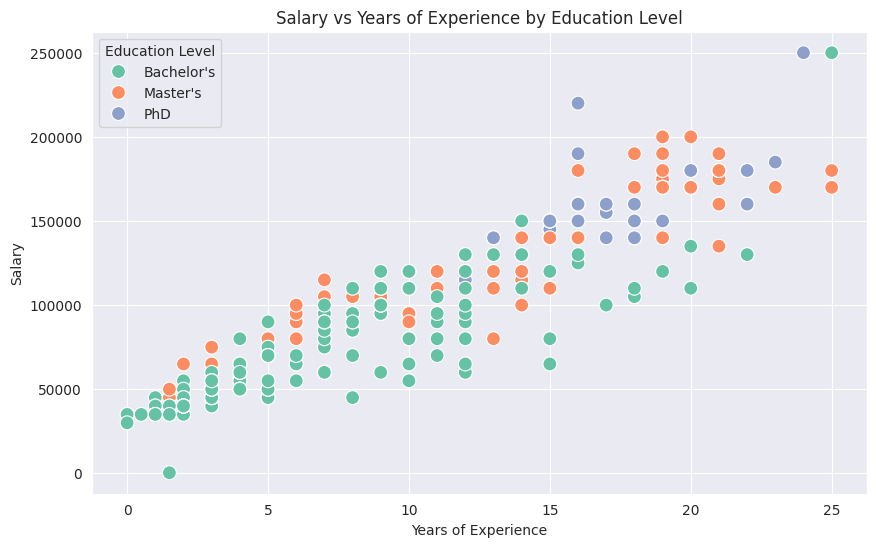

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Years of Experience", y="Salary", hue="Education Level", palette="Set2", s=100)

# Adding titles and labels
plt.title("Salary vs Years of Experience by Education Level")
plt.xlabel("Years of Experience")
plt.ylabel("Salary")
plt.legend(title="Education Level")

# Display the plot
plt.show()

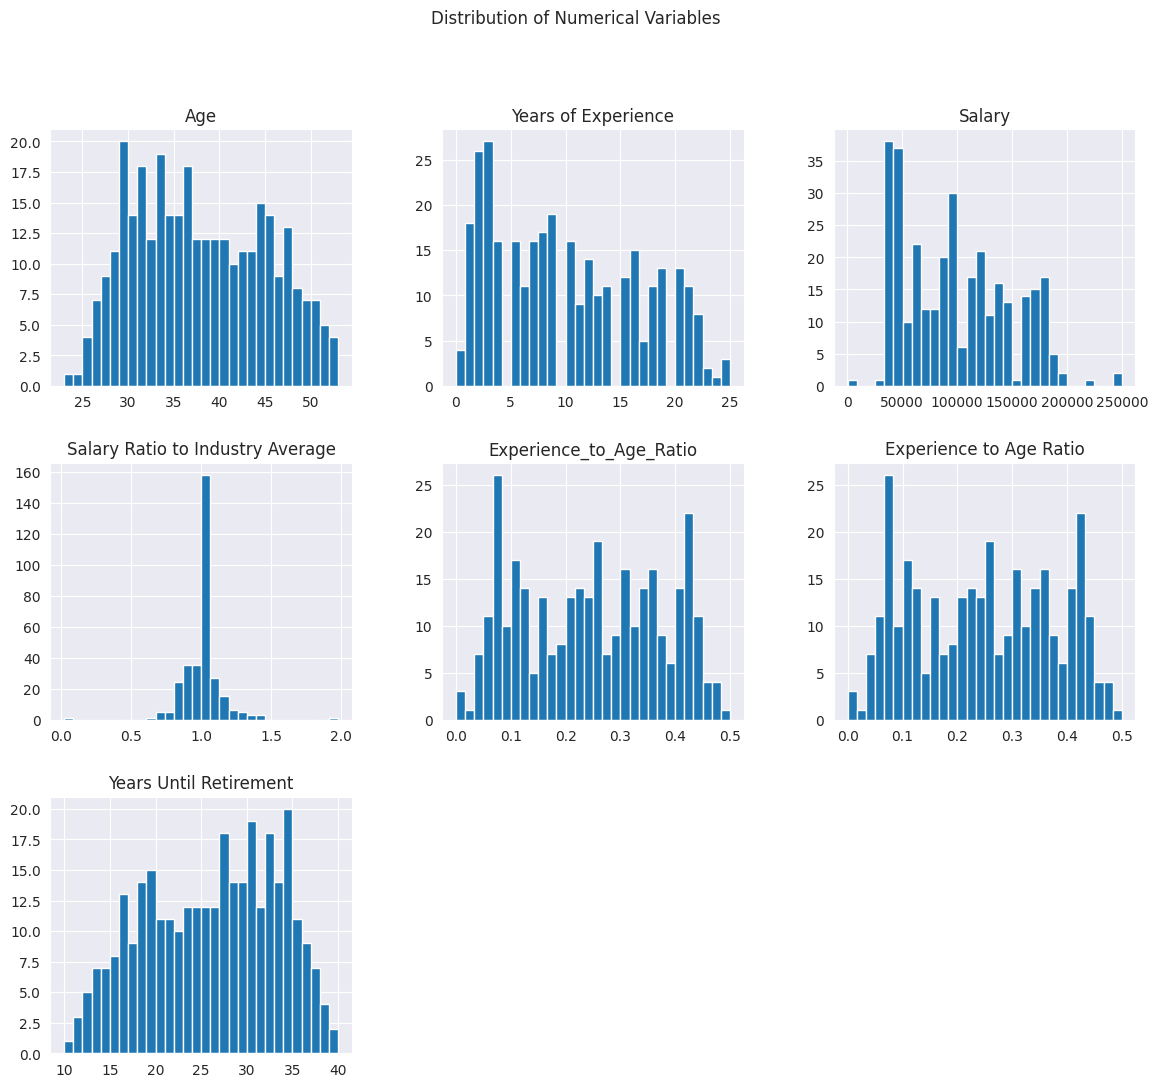

In [ ]:
# Distribution of numerical variables
numerical_cols = df.select_dtypes(include=np.number).columns
df[numerical_cols].hist(bins=30, figsize=(14, 12), layout=(3, 3))
plt.suptitle('Distribution of Numerical Variables')
plt.show()

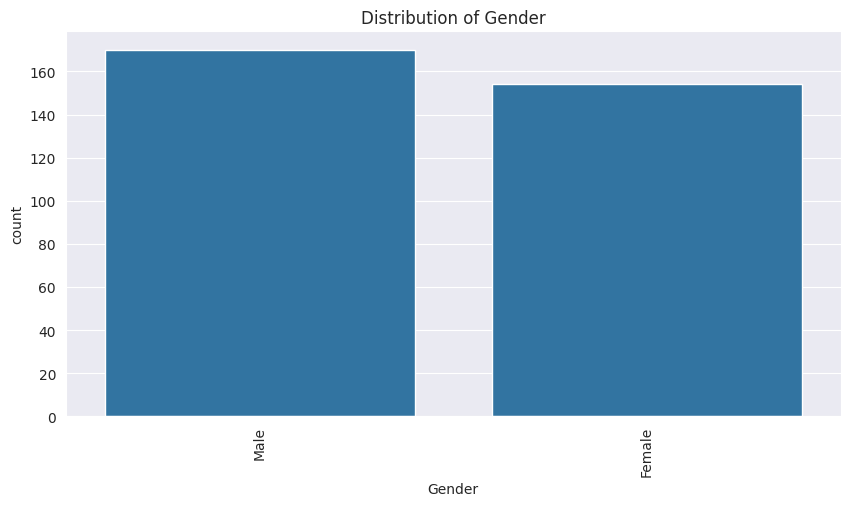

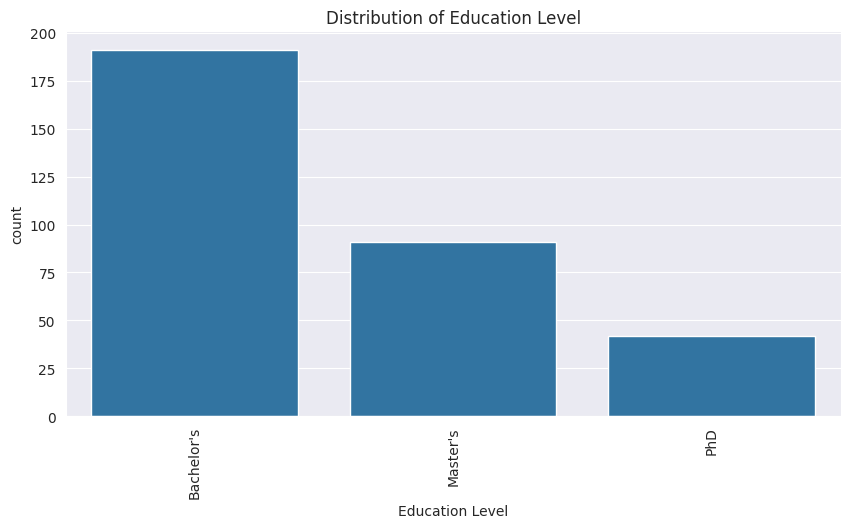

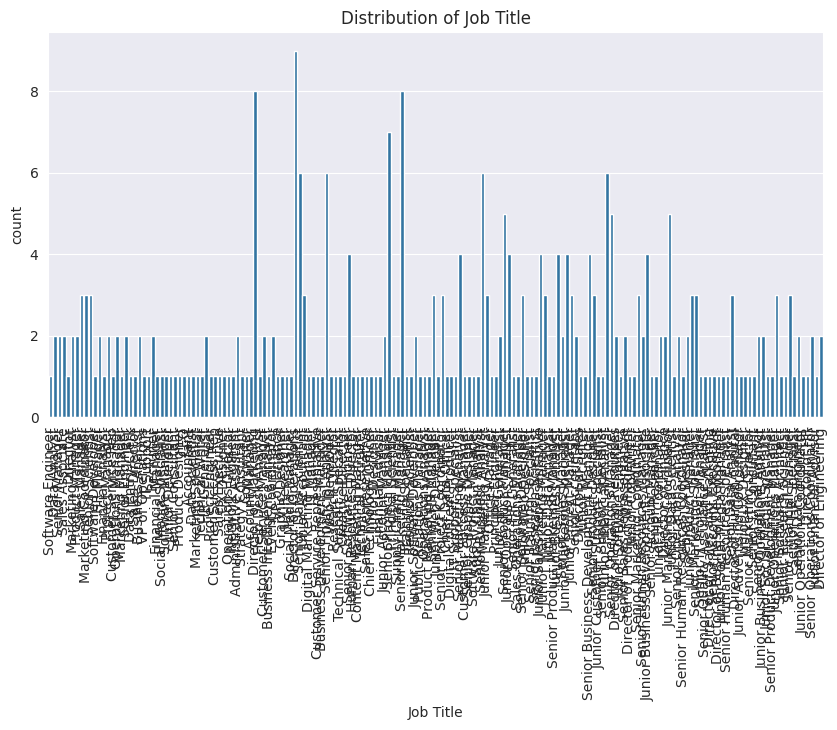

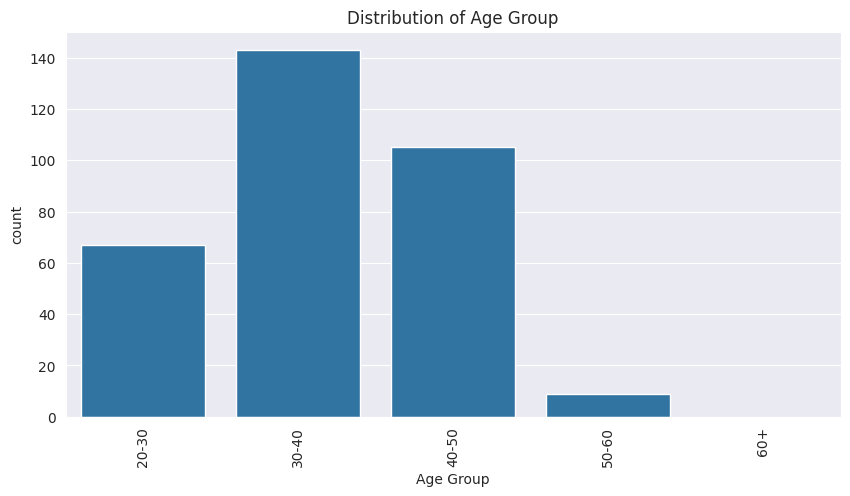

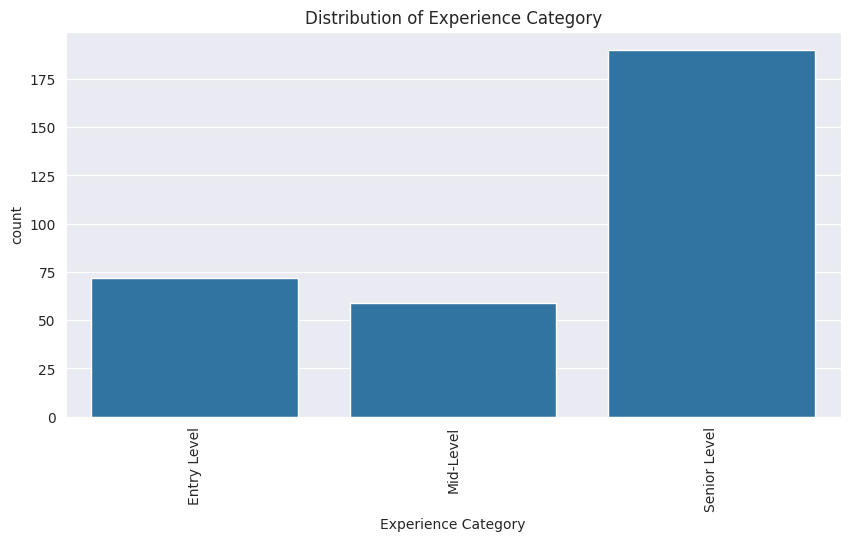

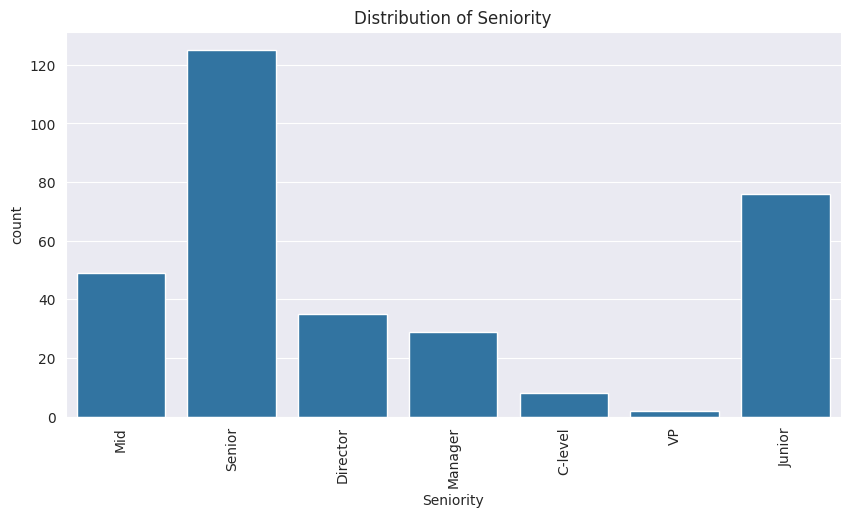

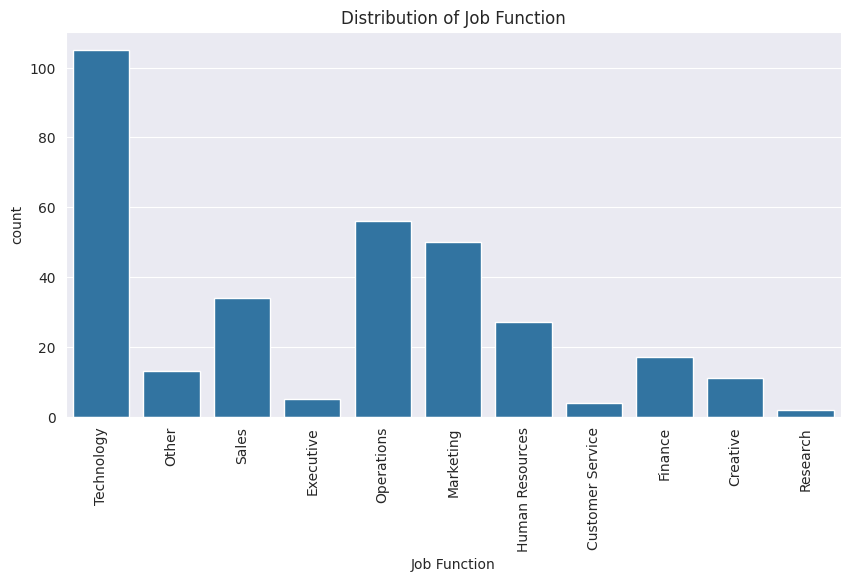

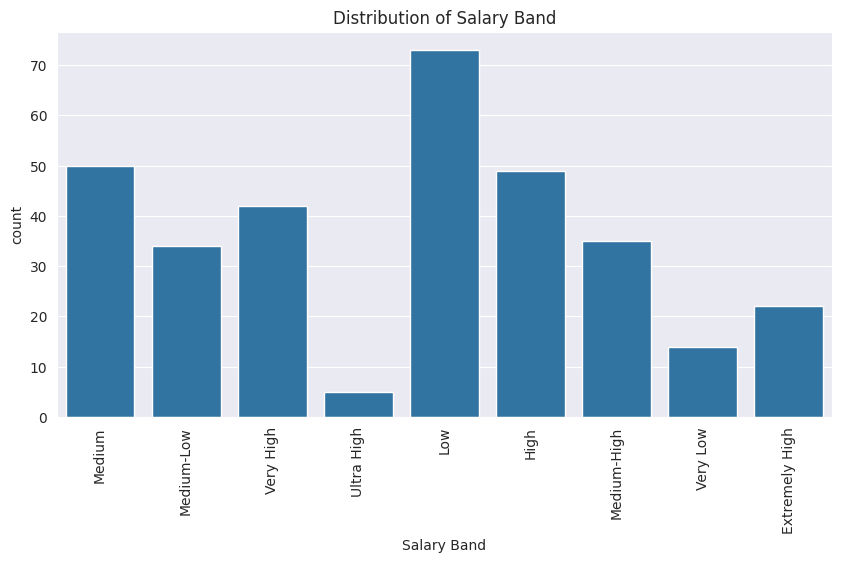

In [ ]:
# Distribution of categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.show()

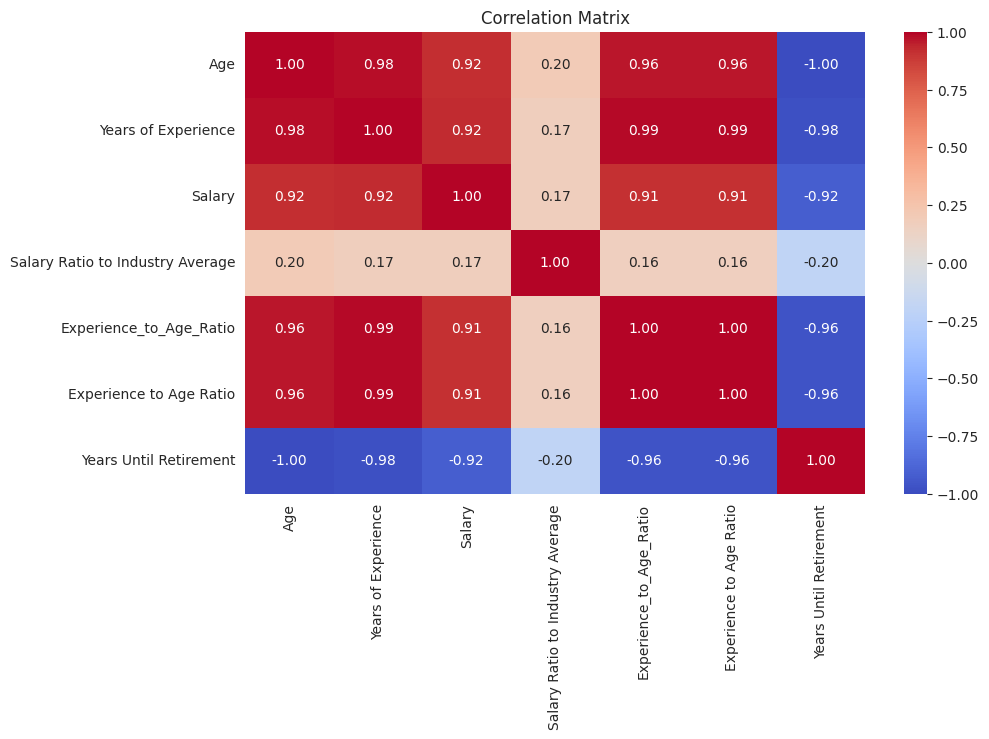

In [ ]:
# Correlation matrix for numerical variables
plt.figure(figsize=(10, 6))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Identify outliers using z-score
# Outliers can significantly affect measures like mean and standard deviation, leading to  misleading interpretations
# outliers may impoact learning process of machine learning models
z_scores = np.abs(zscore(df[numerical_cols]))
outliers = (z_scores > 3).sum(axis=0)
print("\nOutliers in Numerical Columns:")
print(outliers)


Outliers in Numerical Columns:
Age                                 0
Years of Experience                 0
Salary                              2
Salary Ratio to Industry Average    4
Experience_to_Age_Ratio             0
Experience to Age Ratio             0
Years Until Retirement              0
dtype: int64


In [ ]:
# Discuss any skewness or imbalances in the data
# Many statistical test and machine learning models assume normally distributed data.
# Skewed data can violate these assumptions and affect performancec
# Skewness can affect interpretability of data and models. For e.g. a highly skewed salary distribution might not
# reflect the true central tendency of the data
skewness = df[numerical_cols].skew()
print("\nSkewness in Numerical Columns:")
print(skewness)


Skewness in Numerical Columns:
Age                                 0.195202
Years of Experience                 0.358371
Salary                              0.437057
Salary Ratio to Industry Average    0.349366
Experience_to_Age_Ratio            -0.012100
Experience to Age Ratio            -0.012100
Years Until Retirement             -0.195202
dtype: float64


In [ ]:
# Check for any imbalances in categorical data
print("\nCategory Imbalance:")
for col in categorical_cols:
    imbalance = df[col].value_counts(normalize=True) * 100
    print(f"\n{col}:\n{imbalance}")


Category Imbalance:

Gender:
Gender
Male      52.469136
Female    47.530864
Name: proportion, dtype: float64

Education Level:
Education Level
Bachelor's    58.950617
Master's      28.086420
PhD           12.962963
Name: proportion, dtype: float64

Job Title:
Job Title
Director of Operations             2.777778
Director of Marketing              2.469136
Senior Marketing Manager           2.469136
Senior Project Manager             2.160494
Senior Business Analyst            1.851852
                                     ...   
Business Development Manager       0.308642
Customer Service Representative    0.308642
IT Manager                         0.308642
Digital Marketing Manager          0.308642
Junior Web Developer               0.308642
Name: proportion, Length: 174, dtype: float64

Age Group:
Age Group
30-40    44.135802
40-50    32.407407
20-30    20.679012
50-60     2.777778
60+       0.000000
Name: proportion, dtype: float64

Experience Category:
Experience Category
Senior 

In [ ]:
df.head()

Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary Age Group  Salary Ratio to Industry Average Experience Category  \
0   90000.0     30-40                          1.000000           Mid-Level   
1   65000.0     20-30                          0.896552         Entry Level   
2  150000.0     40-50                          0.937500        Senior Level   
3   60000.0     30-40                          1.200000           Mid-Level   
4  200000.0     50-60                          1.000000        Senior Level   

  Seniority Job Function Salary Band  Experience_to_Age_Ratio  \
0       Mid   Technology      Medium                 0.156250   
1       Mid   Technology  Medium-Low                 0.107143   
2    Senior        Other   Very High                 0.333333   
3       Mid        Sales  Medium-Low                 0.194444   
4  Director    Executive  Ultra High                 0.384615   

   Age at First Job  Experience to Age Ratio  Years Until Retirement  
0              27.0                 0.156250                    31.0  
1              25.0                 0.107143                    35.0  
2              30.0                 0.333333                    18.0  
3              29.0                 0.194444                    27.0  
4              32.0                 0.384615                    11.0

In [ ]:
df['Education Level'].value_counts()

Education Level
Bachelor's    191
Master's       91
PhD            42
Name: count, dtype: int64

In [ ]:
# There are quite a lot of distinct job titles that may potentially skew the data
df['Job Title'].nunique()

174

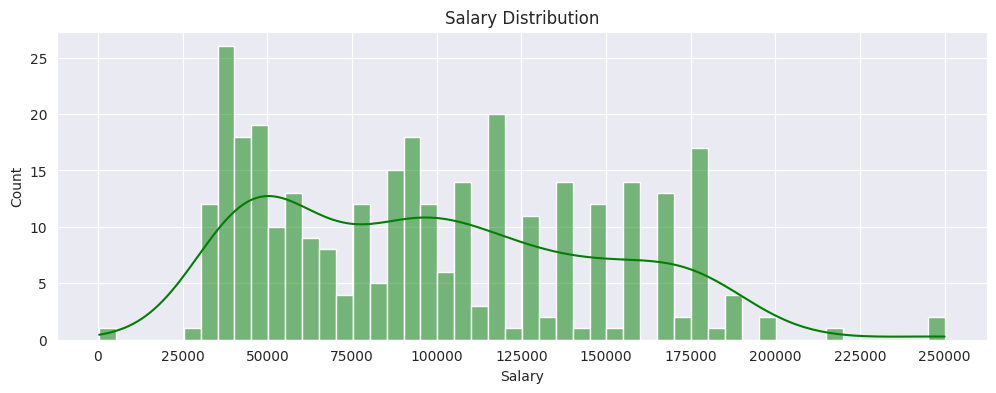

In [ ]:
# Distribution of income
plt.figure(figsize=(12,4))
sns.histplot(df['Salary'], color='green', label='Salary', kde=True, binwidth=5000)
plt.title("Salary Distribution")
plt.xticks(np.arange(0,250001,25000))
plt.show()

In [ ]:
# Separate our feature and target variables
X = df.drop('Salary', axis=1)
y = df['Salary']
X.shape, y.shape

((324, 14), (324,))

# REFACTORING OF CODES FOR LABEL ENCODER AND SCALING

In [ ]:
################################################################################
##############     REFACOTRING OF CODES USING PIPELINES     ####################
################################################################################

# Columns to be encoded
categorical_features = ['Gender', 'Job Title', 'Education Level', 'Experience Category', 'Age Group', 'Seniority', 'Job Function', 'Salary Band']
# Columns to be scaled
numerical_features = X.columns.difference(categorical_features)

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Bundle preprocessing for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create the pipeline:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=10))
])

# Train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 10)

# Define the parameter grid for GridSearchCV:
# We need to prefixed with the name of the step it belongs to (i.e. in this case 'regressor')
# This for disambiguation: When we have a complex pipeline with multiple steps, there might be
# parameters with the same name in different steps. Prefixing parameters ensures that 'GridSearchCV'
# knows exactly which parameter in which steps we are referring to.
params_grid = {
    'regressor__n_estimators':[30, 50, 70],
    'regressor__criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'regressor__max_depth':[20, 30],
    'regressor__min_samples_split' : [6,8,12],
    'regressor__max_leaf_nodes' : [40,50,60],
    'regressor__max_features':['sqrt','log2']
}

# Define the scoring metrics
scoring = {
    'r2': 'r2',
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'MAE': make_scorer(mean_absolute_error)
}

# Optimize hyperparameters using GridSearchCV:
# During the CV, 'GridSearchCV' evaluates all specified scoring metrics for each combination of hyperparameters
# Then after evaluating, it selects the best model based on the R² score (since refit='R2').
# The best model, determined by highest R² score, is then refitted on the entire training dataset to
# potentially improve its performance by utilizing all the available data
grid_search = GridSearchCV(pipeline, param_grid=params_grid, scoring=scoring, refit='r2', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("\n")
print(f'Best parameters found: {best_params} with training data')

# Accessing the scores for each metric
results = grid_search.cv_results_
# Loops over each scoring metric defined in the 'scoring' dictionary
# Check if the current scorer is 'R2'.
# If it is 'R2', print the best R² score using grid_search.best_score_.
# If it is not 'R2', print the best score for the current scorer by finding the maximum of results[f'mean_test_{scorer}'].
print("\nBest CV Scores:")
for scorer in scoring:
  print(f"Best {scorer}: {grid_search.best_score_ if scorer =='R2' else max(results[f'mean_test_{scorer}'])}")

# Predict using the best found parameters and model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate additional scoring metrics
r2_result = r2_score(y_test, y_pred)
mse_result = mean_squared_error(y_test, y_pred)
rmse_result = np.sqrt(mean_squared_error(y_test, y_pred))
mae_result = mean_absolute_error(y_test, y_pred)

print("\nTest Set Scores:")
print(f"R² Score {r2_result}")
print(f"Mean Squared Error (MSE) {mse_result}")
print(f"Root Mean Squared Error (MSE) {rmse_result}")
print(f"Mean Absoulte Error (MAE) {mae_result}")



Best parameters found: {'regressor__criterion': 'poisson', 'regressor__max_depth': 30, 'regressor__max_features': 'log2', 'regressor__max_leaf_nodes': 60, 'regressor__min_samples_split': 6, 'regressor__n_estimators': 50} with training data

Best CV Scores:
Best r2: 0.944142549082898
Best MSE: 182314736.85363248
Best RMSE: 13185.045256347663
Best MAE: 8693.566310593318

Test Set Scores:
R² Score 0.9218031812982217
Mean Squared Error (MSE) 132154474.41828229
Root Mean Squared Error (MSE) 11495.845963576681
Mean Absoulte Error (MAE) 8694.093677131685


# Random Forest Results

Best parameters found: {'regressor__criterion': 'poisson', 'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__max_leaf_nodes': 50, 'regressor__min_samples_split': 8, 'regressor__n_estimators': 50} with training data

Best CV Scores:
Best r2: 0.9445971923756729
Best MSE: 278683915.1485591
Best RMSE: 16460.33657317047
Best MAE: 11597.180229688724

Test Set Scores:
R² Score 0.9329123517676108
Mean Squared Error (MSE) 113379713.3860688
Root Mean Squared Error (MSE) 10647.991049304503
Mean Absoulte Error (MAE) 7433.710602921641

# Observations:
1. R² Score (0.8106):

  *   An R² score of 0.8106 means that approximately 81.06% of the variance in the employee salaries can be explained by the features used in the model. This indicates that the model has a good level of explanatory power

2. MSE, RMSE, and MAE: These error metrics provide a sense of the model's prediction accuracy. The RMSE of 17,890.06 and MAE of 14,093.52 indicate that the average prediction error is significant when considering the unit of salaries. This could suggest that while the model has good explanatory power (high R²), there is still room for improvement in reducing prediction errors.

Interpretation in Context:
For a salary prediction problem, these numbers mean that while your model is good at explaining the variability in salaries (as indicated by the R² score), it still has a notable average error in predictions. If the salaries are in a typical currency unit like USD or SGD, an average error of around 14,093.52 could be quite substantial depending on the typical salary range in your dataset. It suggests that while your model is on the right track, further improvements (such as more features, different model types, or hyperparameter tuning) could help to reduce the prediction errors.

High R² Score: Good, as it indicates a high level of explained variance.
Low RMSE and MAE: Good, as it indicates that the model's predictions are close to the actual values.
Therefore, in the context of your salary prediction problem, while a high R² score is desirable, you also want to aim for low RMSE and MAE to ensure that your model is making accurate predictions with small errors.

# FEATURE IMPORTANCE

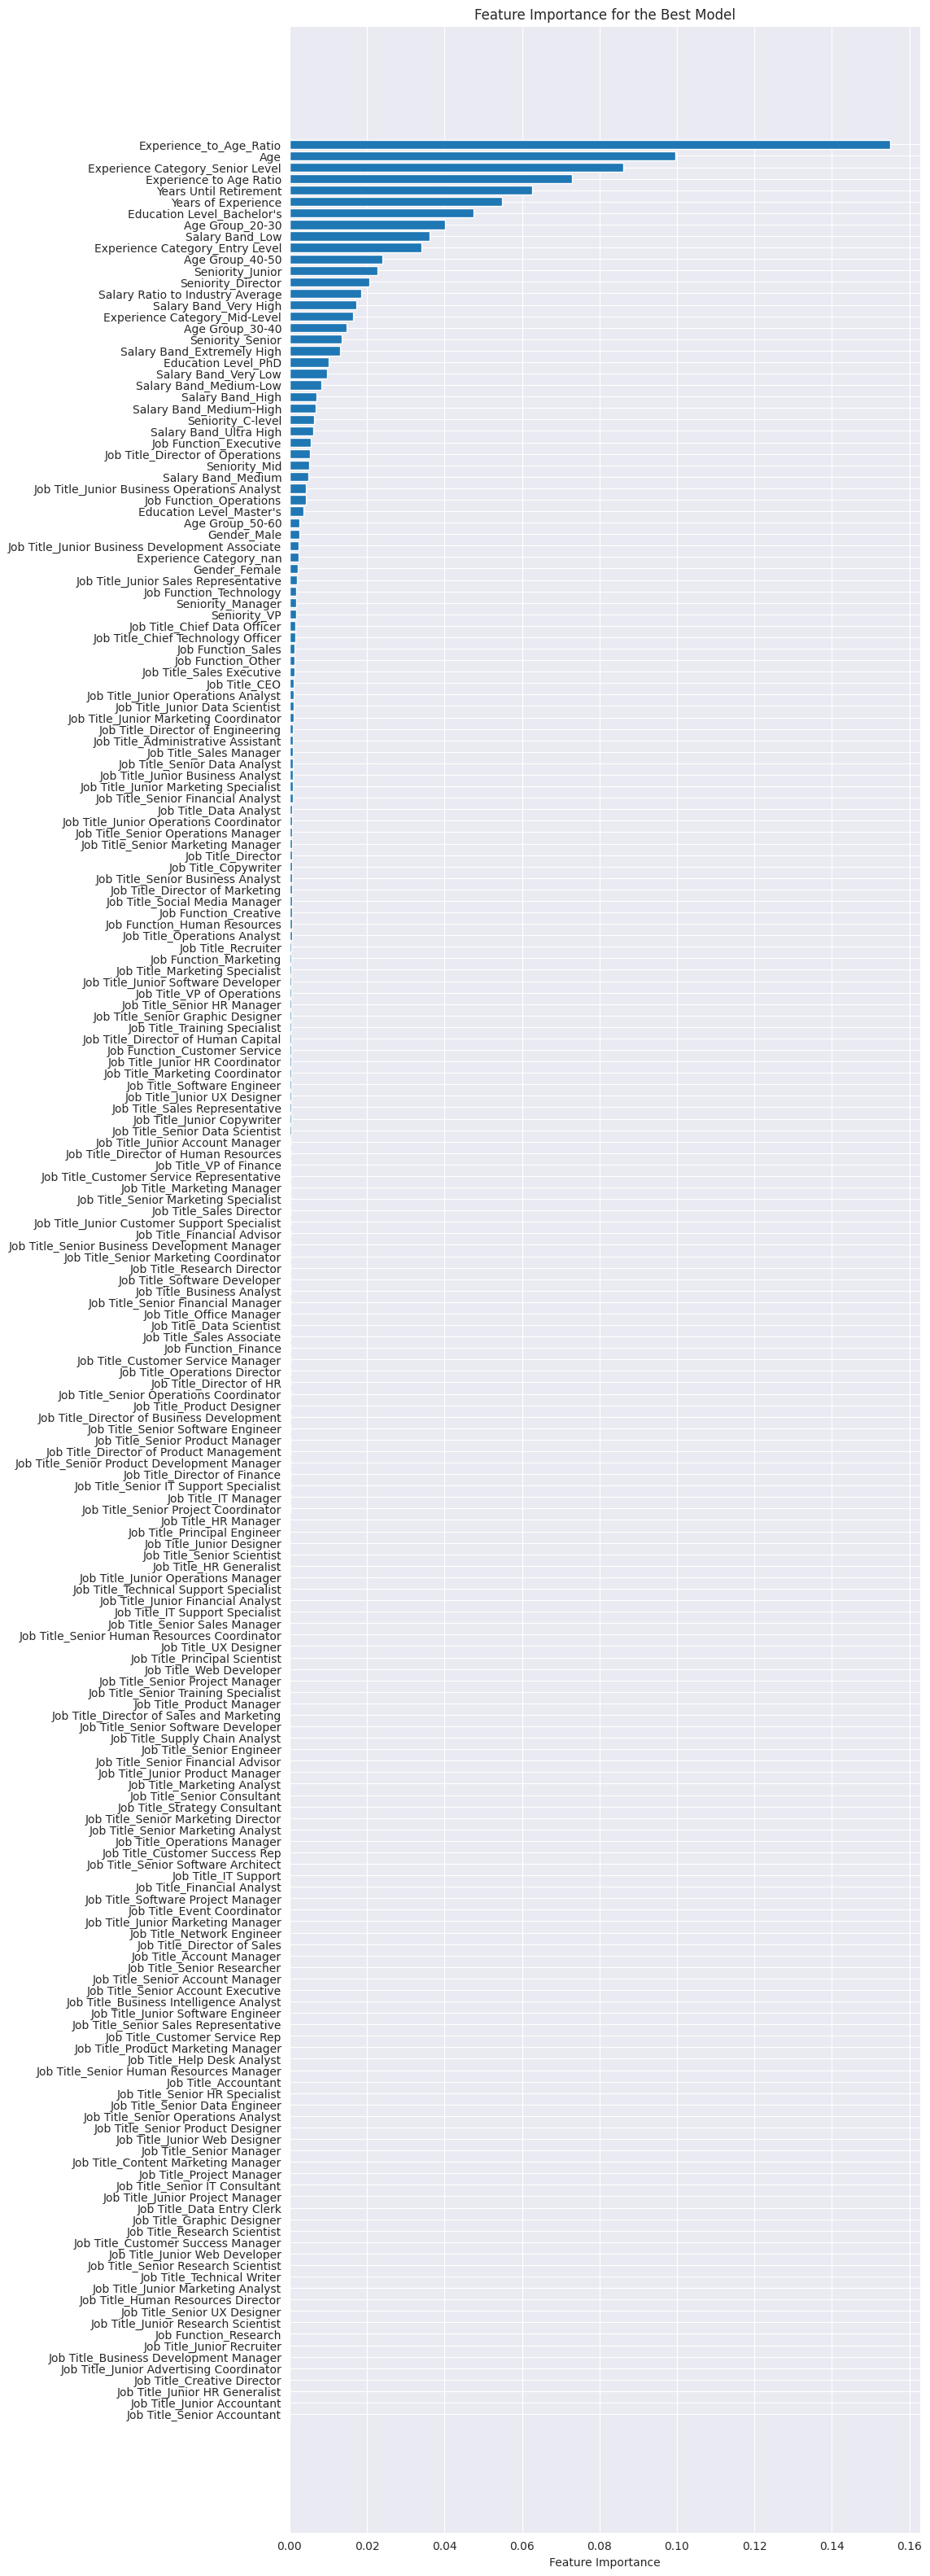

In [ ]:
# Extract feature importance
feature_importances = best_model.named_steps['regressor'].feature_importances_  # Accesses the RandomForestRegressor instance within your pipeline., then extract feature importances
# Get feature names after preprocessing
# Access the preprocessing step of the best model found by the grid search.
# Within the preprocessor, access the transformer applied to the categorical features. The 'cat' key refers to the categorical transformer defined in the ColumnTransformer.
# Within the categorical transformer pipeline, access the OneHotEncoder step. The step was named 'OneHotEncoder' in the pipeline definition.
onehot_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat']['OneHotEncoder'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numerical_features, onehot_feature_names])

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# plot feature importances
plt.figure(figsize=(10,40))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for the Best Model')
plt.gca().invert_yaxis()
plt.show()

# XGBoost Regressor

In [ ]:
# Columns to be encoded
categorical_features = ['Gender', 'Job Title', 'Education Level', 'Experience Category', 'Age Group', 'Seniority', 'Job Function', 'Salary Band']
# Columns to be scaled
numerical_features = X.columns.difference(categorical_features)

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Bundle preprocessing for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Create the pipeline:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=10))
])

# Train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

# Define the parameter grid for GridSearchCV:
# We need to prefixed with the name of the step it belongs to (i.e. in this case 'regressor')
# This for disambiguation: When we have a complex pipeline with multiple steps, there might be
# parameters with the same name in different steps. Prefixing parameters ensures that 'GridSearchCV'
# knows exactly which parameter in which steps we are referring to.
params_grid = {
    'regressor__n_estimators': [70, 90, 110],
    'regressor__max_depth': [6, 8],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.6, 0.7, ],
    'regressor__colsample_bytree': [0.6, 0.8],
    'regressor__gamma': [0.01, 0.1],
    'regressor__min_child_weight': [2, 3],
    'regressor__reg_alpha': [0.01, 0.1],
    'regressor__reg_lambda': [1, 2]
}

# Define the scoring metrics
scoring = {
    'r2': 'r2',
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))),
    'MAE': make_scorer(mean_absolute_error)
}

# Optimize hyperparameters using GridSearchCV:
# During the CV, 'GridSearchCV' evaluates all specified scoring metrics for each combination of hyperparameters
# Then after evaluating, it selects the best model based on the R² score (since refit='R2').
# The best model, determined by highest R² score, is then refitted on the entire training dataset to
# potentially improve its performance by utilizing all the available data
grid_search = GridSearchCV(pipeline, param_grid=params_grid, scoring=scoring, refit='r2', cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("\n")
print(f'Best parameters found: {best_params} with training data')

# Accessing the scores for each metric
results = grid_search.cv_results_
# Loops over each scoring metric defined in the 'scoring' dictionary
# Check if the current scorer is 'R2'.
# If it is 'R2', print the best R² score using grid_search.best_score_.
# If it is not 'R2', print the best score for the current scorer by finding the maximum of results[f'mean_test_{scorer}'].
print("\nBest CV Scores:")
for scorer in scoring:
    print(f"Best {scorer}: {grid_search.best_score_ if scorer =='r2' else max(results[f'mean_test_{scorer}'])}")

# Predict using the best found parameters and model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate additional scoring metrics
r2_result = r2_score(y_test, y_pred)
mse_result = mean_squared_error(y_test, y_pred)
rmse_result = np.sqrt(mean_squared_error(y_test, y_pred))
mae_result = mean_absolute_error(y_test, y_pred)

print("\nTest Set Scores:")
print(f"R² Score {r2_result}")
print(f"Mean Squared Error (MSE) {mse_result}")
print(f"Root Mean Squared Error (RMSE) {rmse_result}")
print(f"Mean Absolute Error (MAE) {mae_result}")



Best parameters found: {'regressor__colsample_bytree': 0.8, 'regressor__gamma': 0.01, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__min_child_weight': 2, 'regressor__n_estimators': 90, 'regressor__reg_alpha': 0.01, 'regressor__reg_lambda': 1, 'regressor__subsample': 0.6} with training data

Best CV Scores:
Best r2: 0.9643680879874772
Best MSE: 151422284.1084715
Best RMSE: 12116.970730762305
Best MAE: 7391.225909985388

Test Set Scores:
R² Score 0.9606440902433669
Mean Squared Error (MSE) 66512418.98953247
Root Mean Squared Error (RMSE) 8155.514636706409
Mean Absolute Error (MAE) 5961.736899038461


# Comparing Scores of Random Forest and XGBoost

## Inferences


*   R² Score:

Training: The R² score for XGBoost (0.9644) is higher than Random Forest (0.9441). This indicates that XGBoost explains more variance in the training data.

Test: The R² score for XGBoost (0.9606) is higher than Random Forest (0.9218). This suggests that XGBoost also performs better on unseen data.




*   Mean Absolute Error (MAE):


Training: The MAE for XGBoost (7391.23) is lower than Random Forest (8693.5663), suggesting that the average error magnitude is smaller with XGBoost on the training data.

Test: The MAE for XGBoost (5961.74) is lower than Random Forest (8694.09), showing that XGBoost also has smaller errors on the test data.



## Summary
*   XGBoost outperforms Random Forest on all metrics, both on the training and test sets.
*   Higher R² and Lower Errors: XGBoost has a higher R² score, indicating better variance explanation, and lower error metrics (MSE, RMSE, MAE), indicating better predictive accuracy and smaller error magnitudes.
*   Generalization: XGBoost generalizes better to unseen data compared to  
Random Forest, as evidenced by its superior test set performance.
*   Overall, these results suggest that XGBoost is a more effective model for your dataset compared to Random Forest, providing better accuracy and more reliable predictions.



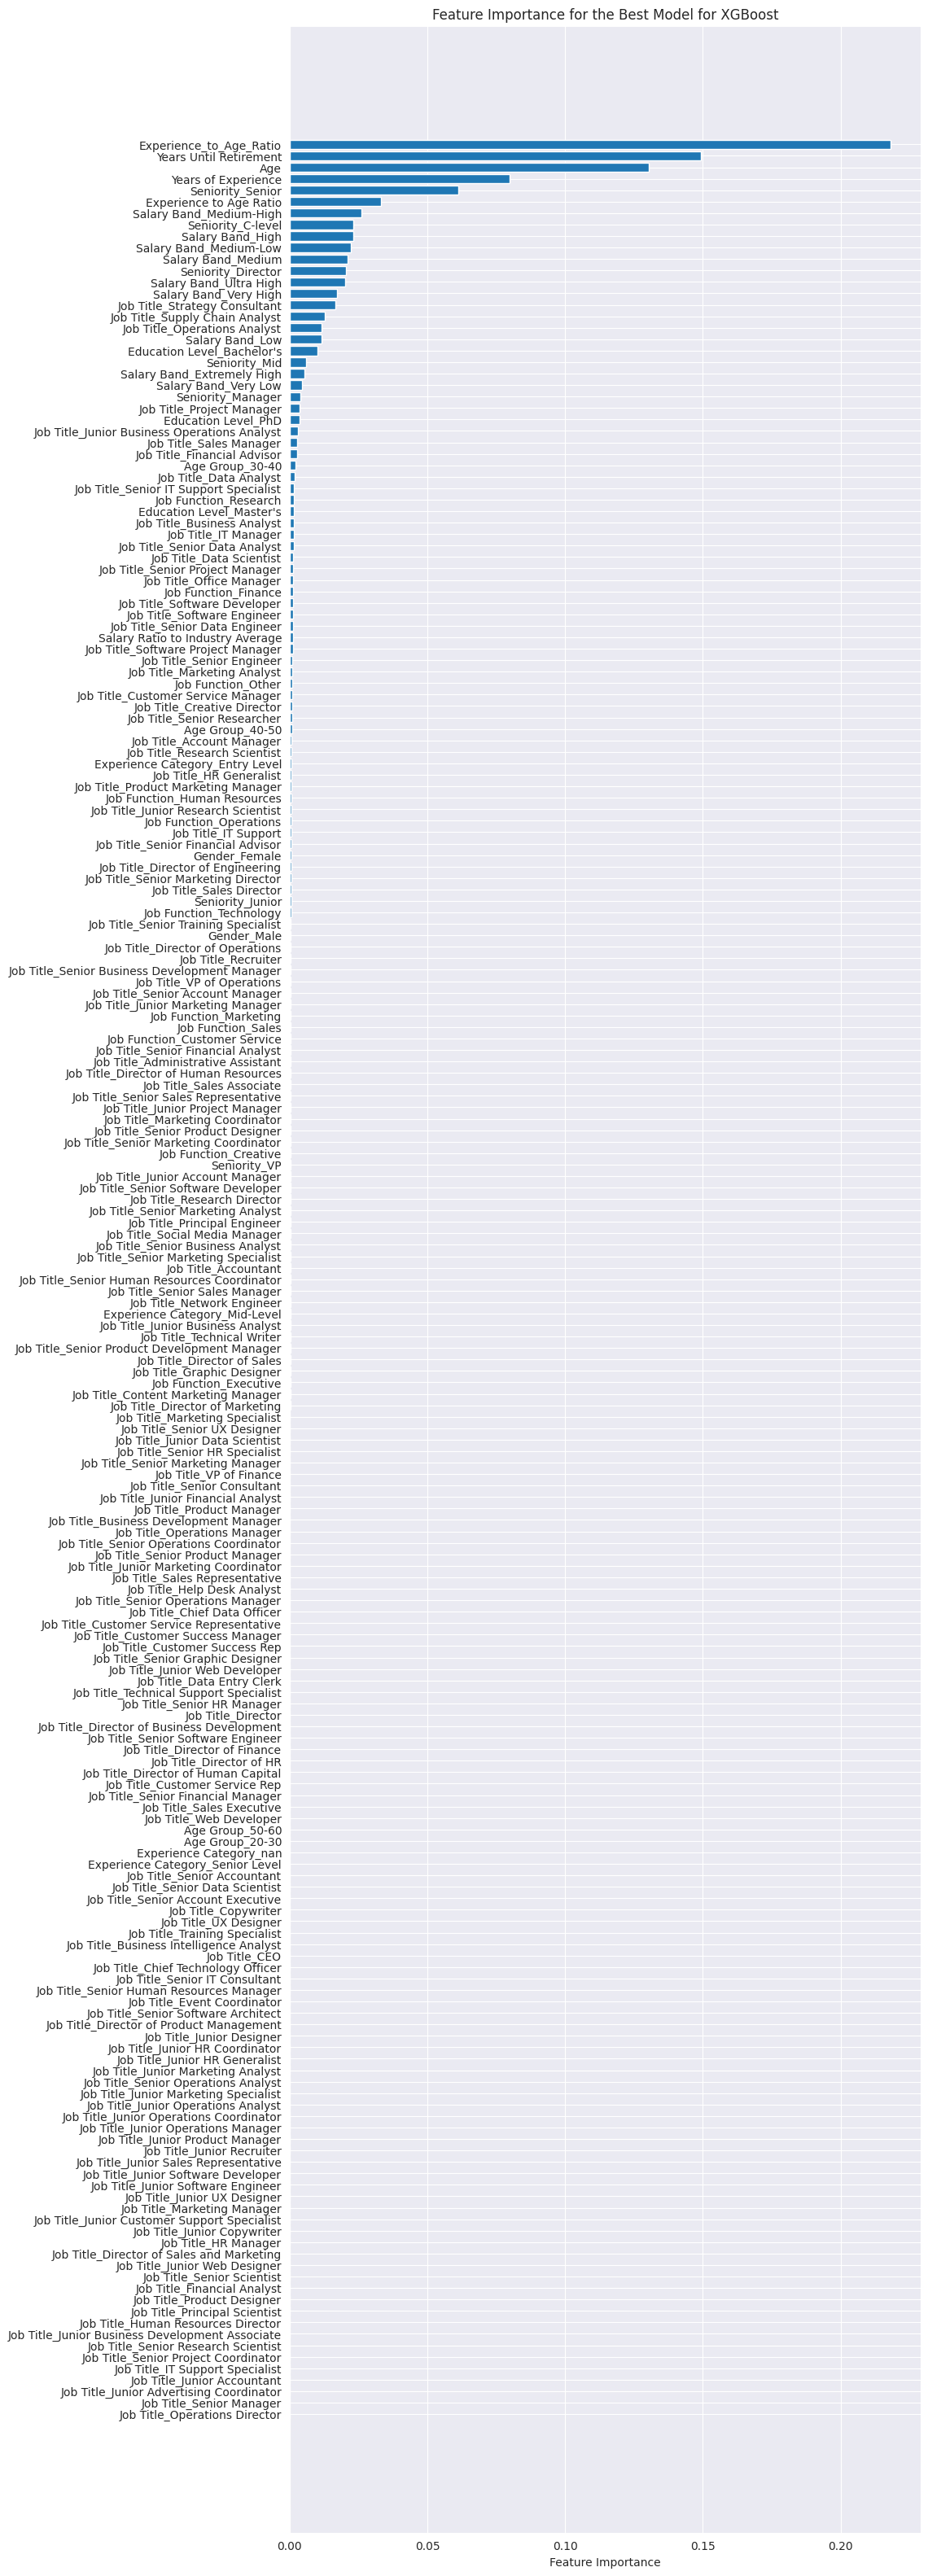

In [ ]:
# Extract feature importance
feature_importances = best_model.named_steps['regressor'].feature_importances_  # Accesses the RandomForestRegressor instance within your pipeline., then extract feature importances
# Get feature names after preprocessing
# Access the preprocessing step of the best model found by the grid search.
# Within the preprocessor, access the transformer applied to the categorical features. The 'cat' key refers to the categorical transformer defined in the ColumnTransformer.
# Within the categorical transformer pipeline, access the OneHotEncoder step. The step was named 'OneHotEncoder' in the pipeline definition.
onehot_feature_names = best_model.named_steps['preprocessor'].named_transformers_['cat']['OneHotEncoder'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numerical_features, onehot_feature_names])

# Sort features by importance
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# plot feature importances
plt.figure(figsize=(10,40))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align='center')
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance for the Best Model for XGBoost')
plt.gca().invert_yaxis()
plt.show()

# TRAIN TEST SPLIT

In [ ]:
# Train test split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(259, 5) (259,) (65, 5) (65,)


# LINEAR REGRESSION

In [ ]:
## Linear Regression Model

def linear_regression(X_train, y_train, X_test, y_test):
  lr = LinearRegression()
  lr.fit(X_train, y_train)
  pred = lr.predict(X_test)
  return pred

LR_predicted = linear_regression(X_train, y_train, X_test, y_test)

In [ ]:
# Use r2 score to evaluate
# An R-squared value shows how well the model predicts the outcome of the dependent variable.
# A value of 1 indicates that the model predicts 100% of the r/s and a value of 0.5 indicates that the model predicts 50%
# The r2 score is pretty high which indicates that the relationship between the features and salary is approximately linear
r2_result = r2_score(y_test, LR_predicted)
print("R² Score for Linear Regression:", r2_result)

R² Score for Linear Regression: 0.8068242244630575


In [ ]:
# Grid search cv function for optimizing hyperparameters
def grid_search(estimator, parameters, X, y):
  grid = GridSearchCV(estimator, param_grid = parameters)
  grid.fit(X, y)
  return grid.best_params_


# Define the parameter grid
params_grid = {
    # Boolean value to specify if a constant (bias or intercept) should be added to the decision function.
    'fit_intercept': [True, False],
    # Number of jobs to run in parallel
    'n_jobs': [-1,1,3,5]

}

#insert parameters and estimator in grid search function
grid_search(LinearRegression(), params_grid, X_train,y_train)

{'fit_intercept': True, 'n_jobs': -1}

# LASSO REGRESSION

In [ ]:
def lasso_regression(X_train, y_train, X_test, y_test):
  lasso = Lasso()
  lasso.fit(X_train, y_train)
  pred = lasso.predict(X_test)
  return pred

# Use r2 score to evaluate
lasso_predicted = lasso_regression(X_train, y_train, X_test, y_test)
r2_result = r2_score(y_test, lasso_predicted)
print("R² Score for Lasso:", r2_result)

R² Score for Lasso: 0.806817599466765


In [ ]:
# Define the parameter grid
param_grid_lasso = {
    'alpha': [0.1, 1, 10, 100],
    'fit_intercept': [True, False]
}

# Set up the GridSearchCV
grid_search_lasso = GridSearchCV(estimator=Lasso(), param_grid=param_grid_lasso, cv=5, scoring='r2')
grid_search_lasso.fit(X_train, y_train)

# Get the best parameters and score
best_params_lasso = grid_search_lasso.best_params_
best_score_lasso = grid_search_lasso.best_score_

# Print
print(f"The best R² Score for Lasso with tuned parameters {best_params_lasso} is {best_score_lasso}")

The best R² Score for Lasso with tuned parameters {'alpha': 100, 'fit_intercept': True} is 0.9007282941775403


# RIDGE REGRESSION

In [ ]:
def ridge_regression(X_train, y_train, X_test, y_test):
  ridge = Ridge()
  ridge.fit(X_train, y_train)
  pred = ridge.predict(X_test)
  return pred

# Use r2 score to evaluate
Ridge_predicted = ridge_regression(X_train, y_train, X_test, y_test)
r2_result = r2_score(y_test, Ridge_predicted)
print("R² Score for Ridge:", r2_result)

R² Score for Ridge: 0.807234031125722


In [ ]:
# Define the parameter grid
param_grid_ridge = {
    'alpha': [0.1, 1, 10, 100],
    'fit_intercept': [True, False]
}

# Set up the GridSearchCV
grid_search_ridge = GridSearchCV(estimator=Ridge(), param_grid=param_grid_ridge, cv=5, scoring='r2')
grid_search_ridge.fit(X_train, y_train)

# Get the best parameters and score
best_params_ridge = grid_search_ridge.best_params_
best_score_ridge = grid_search_ridge.best_score_

# Print
print(f"The best R² Score for Ridge with tuned parameters {best_params_ridge} is {best_score_ridge}")

The best R² Score for Ridge with tuned parameters {'alpha': 10, 'fit_intercept': True} is 0.9017110117879417


# RANDOM FOREST REGRESSOR
Random forest regressor is to train multiple decision tree regressors on different subsets of the training data and input features. The final prediction is then obtained by averaging the predictions of all the individual trees.

In [ ]:
def random_forest_regression(X_train, y_train, X_test, y_test):
  rf = RandomForestRegressor()
  rf.fit(X_train, y_train)
  pred = rf.predict(X_test)
  return pred

# Use r2 score to evaluate
rf_predicted = random_forest_regression(X_train, y_train, X_test, y_test)
r2_result = r2_score(y_test, rf_predicted)
print("R² Score for Random Forest regression:", r2_result)

R² Score for Random Forest regression: 0.8853111970864861


In [ ]:
# Define the parameter grid
param_grid_rf = {
    'n_estimators':[50,100],
    'criterion':['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth':[2,4,8,10],
    'min_samples_split' : [2,4,8,10,20],
    'max_leaf_nodes' : [5,10,15,20,22,24],
    'max_features':['sqrt','log2']
}

# Calculate the total number of combinations
param_combinations = list(itertools.product(param_grid_rf['n_estimators'], param_grid_rf['criterion'],
                                            param_grid_rf['max_depth'], param_grid_rf['min_samples_split'],
                                            param_grid_rf['max_leaf_nodes'], param_grid_rf['max_features']))


# Set up the GridSearchCV with verbose=1 to see the progress
grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid_rf, cv=5, scoring='r2', verbose=3)

# Fit the GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and score
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

# Print
print(f"The best R² Score for Random Forest Regression with tuned parameters {best_params_rf} is {best_score_rf}")


Streaming output truncated to the last 5000 lines.
[CV 3/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=50;, score=0.931 total time=   0.1s
[CV 4/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=50;, score=0.894 total time=   0.1s
[CV 5/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=50;, score=0.909 total time=   0.1s
[CV 1/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=100;, score=0.939 total time=   0.1s
[CV 2/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=100;, score=0.927 total time=   0.1s
[CV 3/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=100;, score=0.934 total

In [ ]:
# Evaluate on test set
rf = RandomForestRegressor(criterion='absolute_error',
                           max_depth=10,
                           max_features='sqrt',
                           max_leaf_nodes=24,
                           min_samples_split=4,
                           n_estimators=50)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)

# r2 score
rf_r2 = r2_score(y_test, pred)
# Print
print(f"The best R² Score for Random Forest Regression with tuned parameters on test set is {rf_r2}")

The best R² Score for Random Forest Regression with tuned parameters on test set is 0.8686728451686542


# GRADIENT BOOSTING REGRESSOR

In [ ]:
def gradient_boosting_regression(X_train, y_train, X_test, y_test):
  rf = GradientBoostingRegressor()
  rf.fit(X_train, y_train)
  pred = rf.predict(X_test)
  return pred

# Use r2 score to evaluate
rf_predicted = gradient_boosting_regression(X_train, y_train, X_test, y_test)
r2_result = r2_score(y_test, rf_predicted)
print("R² Score for Gradient Boosting regression:", r2_result)

R² Score for Gradient Boosting regression: 0.8809392040606568


In [ ]:
# Define the parameter grid
param_grid_gb = {
    'n_estimators':[50,100],
    'criterion':['squared_error', 'friedman_mse', 'absolute_error'],
    'max_depth':[2,4,8,10],
    'min_samples_split' : [2,4,8,10,20],
    'max_leaf_nodes' : [5,10,15,20,22,24],
    'max_features':['sqrt','log2']
}

# Calculate the total number of combinations
param_combinations = list(itertools.product(param_grid_gb['n_estimators'], param_grid_gb['criterion'],
                                            param_grid_gb['max_depth'], param_grid_gb['min_samples_split'],
                                            param_grid_gb['max_leaf_nodes'], param_grid_gb['max_features']))


# Set up the GridSearchCV with verbose=1 to see the progress
grid_search_gb = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid_gb, cv=5, scoring='r2', verbose=3)

# Fit the GridSearchCV
grid_search_gb.fit(X_train, y_train)

# Get the best parameters and score
best_params_gb = grid_search_gb.best_params_
best_score_gb = grid_search_gb.best_score_

# Print
print(f"The best R² Score for Gradient Boosting Regression with tuned parameters {best_params_gb} is {best_score_gb}")


Streaming output truncated to the last 5000 lines.
[CV 2/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=50;, score=0.936 total time=   0.1s
[CV 3/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=50;, score=0.922 total time=   0.1s
[CV 4/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=50;, score=0.885 total time=   0.1s
[CV 5/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=50;, score=0.923 total time=   0.1s
[CV 1/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=100;, score=0.936 total time=   0.1s
[CV 2/5] END criterion=squared_error, max_depth=10, max_features=log2, max_leaf_nodes=15, min_samples_split=2, n_estimators=100;, score=0.931 total 

In [ ]:
# Evaluate on test set
gb = GradientBoostingRegressor(criterion='squared_error',
                           max_depth=10,
                           max_features='sqrt',
                           max_leaf_nodes=24,
                           min_samples_split=4,
                           n_estimators=50)
gb.fit(X_train, y_train)
pred = gb.predict(X_test)

# r2 score
gb_r2 = r2_score(y_test, pred)
# Print
print(f"The best R² Score for Gradient Boosting Regression with tuned parameters on test set is {gb_r2}")

The best R² Score for Gradient Boosting Regression with tuned parameters on test set is 0.88823028586058



# RESULTS with LABEL ENCODER

*   Linear Regression R² Score: 0.8661353480935511
*   Lasso Regression R² Score: 0.9032132228721388
*   Ridge Regression R² Score: 0.9032535629964082
*   Random Forest Regression R² Score: 0.9169762688260296




# CLUSTERING

In order to account for the presence of clusters in our dataset, we can use a clustering algorithm such as k-means to group the data points into a specified number of clusters. Then, we can train separate linear regression models on each cluster to better capture the relationships between the features and target variable within each group.

From the elbow plot, it only seems like there are 2/3 clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

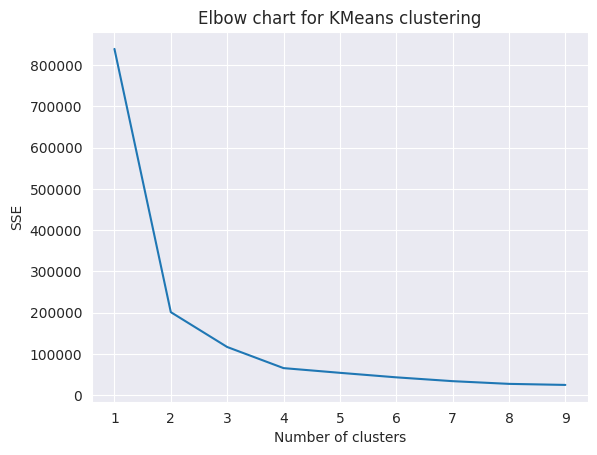

In [ ]:
k_range = range(1, 10)   #considering a range of 10 clusters

# Compute the sum of squared distances (SSE) for each value of k
sse = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

plt.plot(k_range, sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow chart for KMeans clustering')
plt.show()

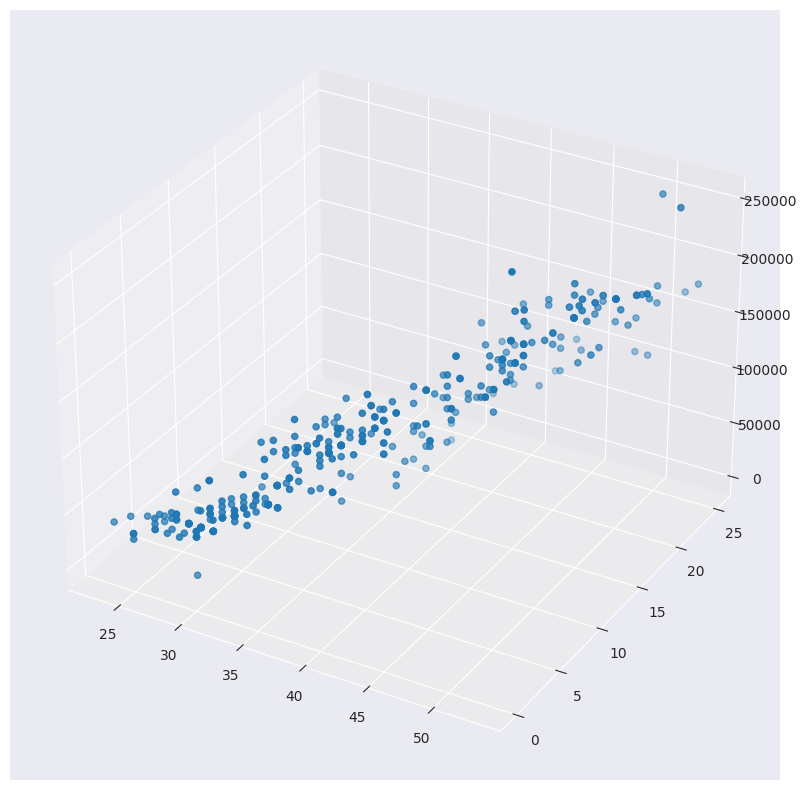

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection="3d")
ax.scatter(df['Age'], df['Years of Experience'], df['Salary'])
plt.show()